Notice

In [ ]:
"""This code was totally inspired by the IBM QAOA Tutorial
   from https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm
   (access in 05/29/2025). You will see a lot of similarities.
   I made a few changes, such as use not using repetitions in the
   QAOA circuit"""

Build up the graph

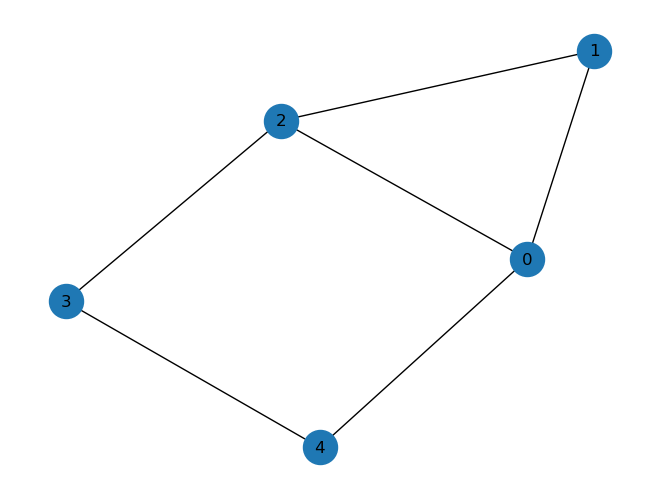

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

Construct the Cost Hamiltonian

In [3]:
list(graph.edge_list())

[(0, 1), (0, 2), (0, 4), (1, 2), (2, 3), (3, 4)]

In [4]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        print(f"edge[0]: {edge[0]}, edge[1]: {edge[1]}")
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))
        print(f"pauli_list: {pauli_list}")

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

edge[0]: 0, edge[1]: 1
pauli_list: [('IIIZZ', 1.0)]
edge[0]: 0, edge[1]: 2
pauli_list: [('IIIZZ', 1.0), ('IIZIZ', 1.0)]
edge[0]: 0, edge[1]: 4
pauli_list: [('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0)]
edge[0]: 1, edge[1]: 2
pauli_list: [('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0), ('IIZZI', 1.0)]
edge[0]: 2, edge[1]: 3
pauli_list: [('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0), ('IIZZI', 1.0), ('IZZII', 1.0)]
edge[0]: 3, edge[1]: 4
pauli_list: [('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0), ('IIZZI', 1.0), ('IZZII', 1.0), ('ZZIII', 1.0)]
Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


Ansatz QAOA based on the Cost Hamiltonian above

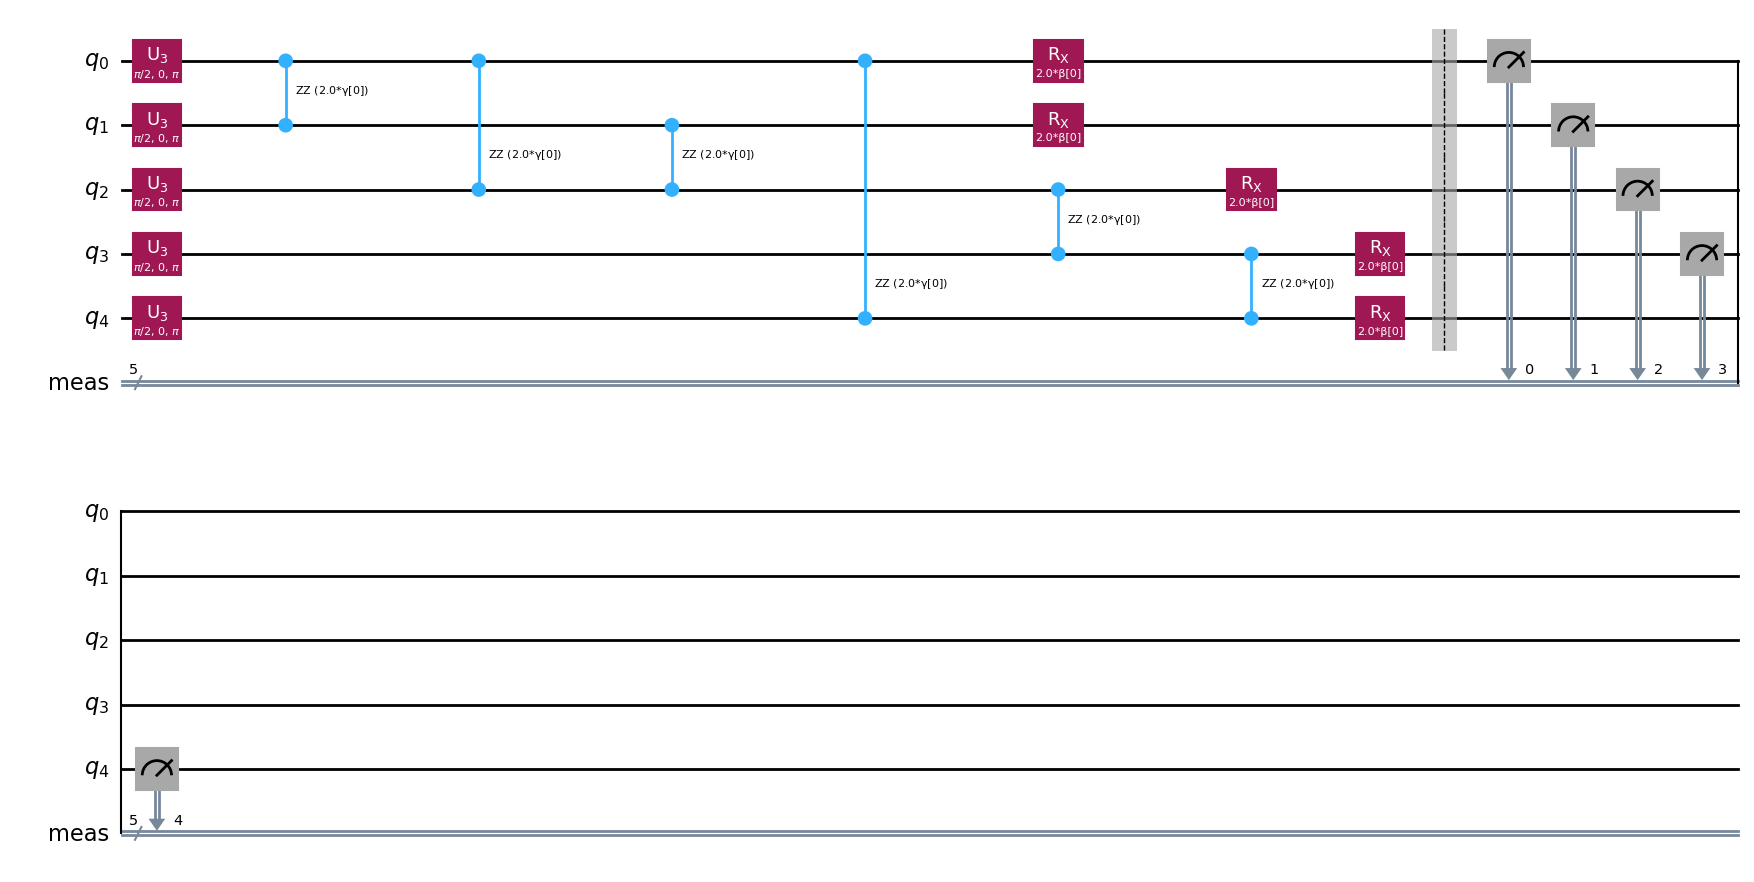

In [5]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()


circuit.decompose(reps=3).draw('mpl')

Login IBM account to release some backend 

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)

Transpile the virtual quantum circuit to the IBM hardware ISA or another 

<IBMBackend('ibm_brisbane')>


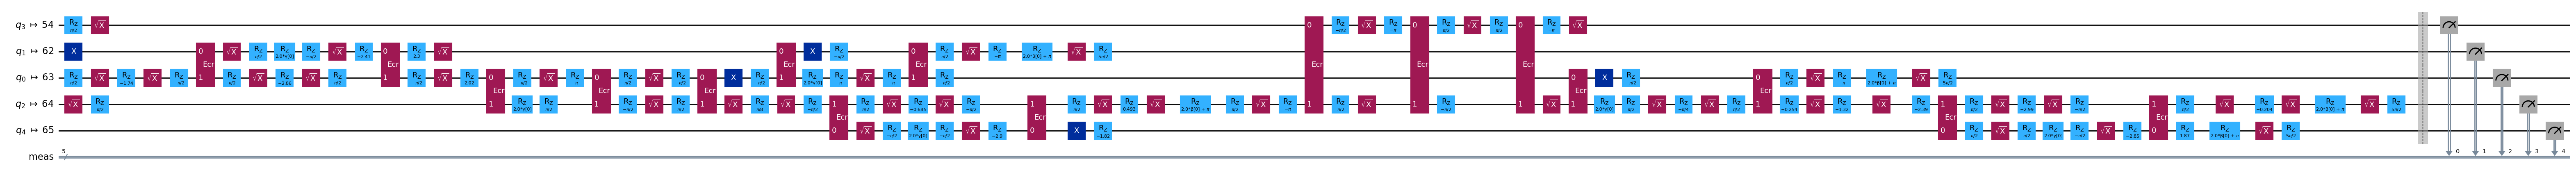

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

Define circuit with initial parameters

In [8]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

Cost Funtion as the minimize scypy funtion subrotine

In [9]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost) #objective_func_vals -> global variable


    return cost

In [10]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.528041468493938
       x: [ 4.352e+00  3.491e-01]
    nfev: 18
   maxcv: 0.0


Plot the cost calculated by the iteration processes

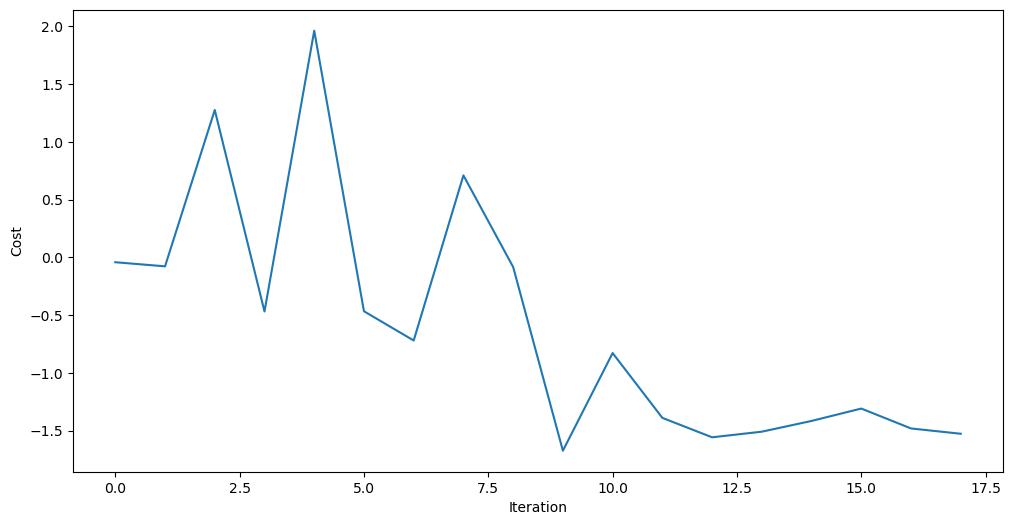

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Assign optimal parameters founded to get the bitstring distribution from the optimal state

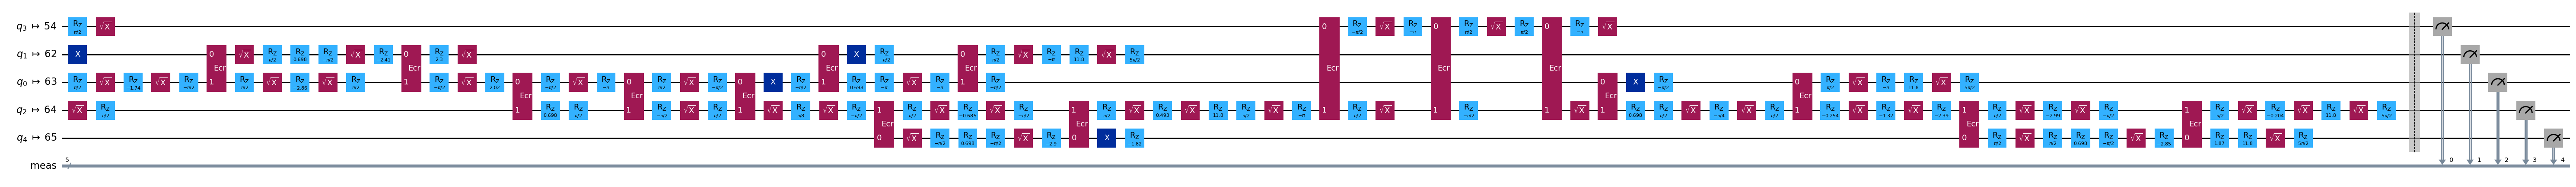

In [16]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [17]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
print(counts_int)
counts_bin = job.result()[0].data.meas.get_counts()
print(counts_bin)
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{27: 195, 31: 81, 20: 773, 5: 470, 26: 543, 13: 423, 30: 152, 21: 470, 9: 694, 19: 342, 18: 459, 22: 723, 10: 483, 12: 388, 11: 689, 4: 186, 14: 298, 3: 245, 17: 292, 28: 252, 16: 167, 1: 162, 8: 221, 24: 117, 23: 246, 2: 108, 6: 151, 15: 154, 7: 127, 25: 174, 29: 115, 0: 100}
{'11011': 195, '11111': 81, '10100': 773, '00101': 470, '11010': 543, '01101': 423, '11110': 152, '10101': 470, '01001': 694, '10011': 342, '10010': 459, '10110': 723, '01010': 483, '01100': 388, '01011': 689, '00100': 186, '01110': 298, '00011': 245, '10001': 292, '11100': 252, '10000': 167, '00001': 162, '01000': 221, '11000': 117, '10111': 246, '00010': 108, '00110': 151, '01111': 154, '00111': 127, '11001': 174, '11101': 115, '00000': 100}
{27: 0.0195, 31: 0.0081, 20: 0.0773, 5: 0.047, 26: 0.0543, 13: 0.0423, 30: 0.0152, 21: 0.047, 9: 0.0694, 19: 0.0342, 18: 0.0459, 22: 0.0723, 10: 0.0483, 12: 0.0388, 11: 0.0689, 4: 0.0186, 14: 0.0298, 3: 0.0245, 17: 0.0292, 28: 0.0252, 16: 0.0167, 1: 0.0162, 8: 0.0221, 24: 0

To obtain the most sampled bitstring

In [18]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 0, 1]


C:\Users\gugam\AppData\Local\Temp\ipykernel_13908\3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


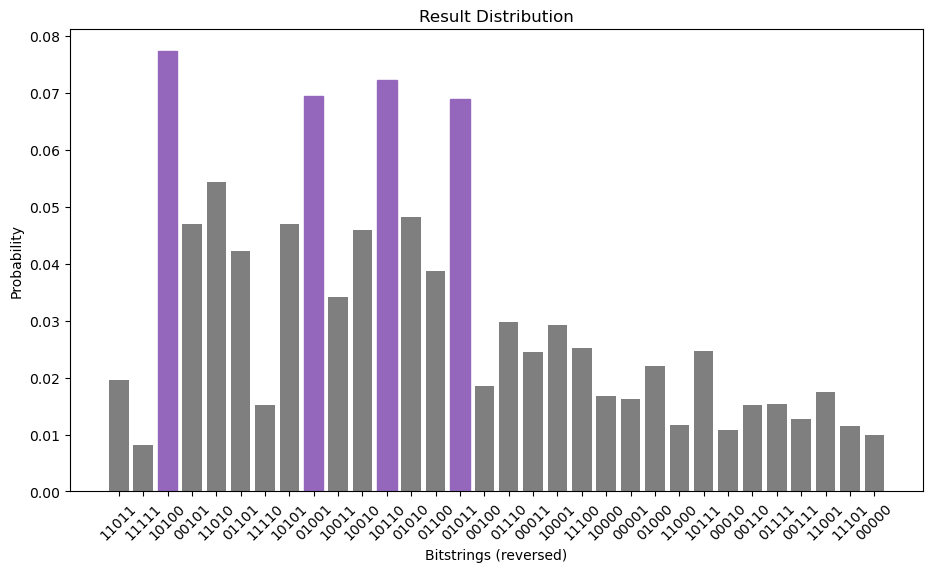

In [19]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

Visualize the best cut

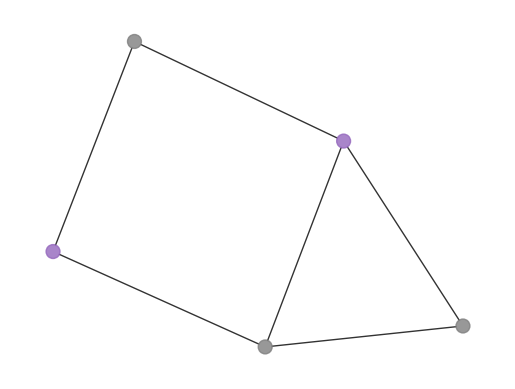

In [20]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

Calculate the max-cut

In [21]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5
